In [0]:
from google.colab import drive
import os
def mountDir(dir, subdir = '', path = 'drive/My Drive/'):
  
    drive.mount('/content/drive')
    print(os.getcwd())
    if subdir == '':
        os.chdir(path + dir)
    else:        
        os.chdir(path + dir + '/' + subdir)
    print(os.getcwd())
    # !ls -la

def storeData(data, filename, ext = '.pkl'):

    pickle.dump(data, open(filename + ext, 'wb') )  
    print(filename + ext + ' saved!')

def loadData(filename, ext = '.pkl'):     

    filename += ext
    data = pickle.load(open(filename, 'rb'))  
    print(filename, ' loaded!')
    
    return data
mountDir('IRProject')

In [0]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow # because cv2.imshow does'nt work in colab
from matplotlib import pyplot as plt

In [96]:
paths = loadData('path_holiday.list', '')
# paths = loadData('path_shoe.list', '')

path_holiday.list  loaded!


Get Features from new image

In [0]:
def histogram(image, bins = 10):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [0]:
def hu_moments(image):
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [0]:
!pip install mahotas
import mahotas
# feature-descriptor-2: Haralick Texture
def haralick(image):
    # convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(image).mean(axis=0)
    # return the result
    return haralick

In [0]:
from skimage.feature import hog

def hog_f(image):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd

In [0]:
def preprocess_image(img):
    # img = cv2.imread(path)                 #original image
    img2 = np.invert(img)                  #invert image
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.Canny(gray, threshold1=30, threshold2=100)    #edge detection
    img2 = cv2.GaussianBlur(img2,(5,5),cv2.BORDER_DEFAULT) #gaussian blur 
    ret, img2 = cv2.threshold(img2, 1, 255, cv2.THRESH_BINARY)     #thresholding 
    img2 = cv2.adaptiveThreshold(img2 ,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
    img2 = np.invert(img2)
    temp = tuple(img2 for i in range(3))
    temp = np.dstack(temp)
    image = cv2.subtract(img, temp)
    return image

In [0]:
def Histogram(image, mask):
    hist = cv2.calcHist([image], [0, 1, 2], mask, (8, 12, 3), [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def get_feature(image):

    # image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    feature = []
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),(0, cX, cY, h)]
    (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        
    ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
    cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
        
    for (startX, endX, startY, endY) in segments:
        cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
        cornerMask = cv2.subtract(cornerMask, ellipMask)
        hist = Histogram(image, cornerMask)
        feature.extend(hist)
    hist = Histogram(image, ellipMask)
    return hist

In [0]:
# typ = 'shoe'
typ = 'holi'
# path = 'shoe1.jpg'
path = 'holi1.jpg'
img = cv2.imread(paths[0])
h0, b0, c = img.shape

feat = dict()

img = cv2.imread(path)
# cv2_imshow(img)
h, b = img.shape[:2]
if h > b:
    r = h0/h
else:
    r = b0/b
img = cv2.resize(img, (0,0), fx=r, fy=r)
x = int((img.shape[0] - h0)/2)
y = int((img.shape[1] - b0)/2)
img = img[x:x+h0,y:y+b0]
filename = path.split('.')[0] + '1.jpg'
cv2.imwrite(filename, img)
feat['color'] = img
grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
feat['hu'] = hu_moments(grey).tolist()
feat['haral'] = haralick(grey).tolist()
img = preprocess_image(img)
feat['hist'] = histogram(img).tolist()
feat['hog'] = hog_f(img).tolist()
feat['seghist'] = get_feature(img).tolist()

    # print(img.shape, cv2.imread(paths[0]).shape)

In [0]:
import numpy as np
from numpy import linalg as LA
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

class VGGNet:
    def __init__(self):
        # weights: 'imagenet'
        # pooling: 'max' or 'avg'
        # input_shape: (width, height, 3), width and height should >= 48
        self.input_shape = (240, 240, 3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        self.model = VGG16(weights = self.weight, input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), pooling = self.pooling, include_top = False)
        self.model.predict(np.zeros((1, 240, 240 , 3))) #change image size

    def extract_features(self, img_path):
        img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feat = self.model.predict(img)
        norm_feat = feat[0]/LA.norm(feat[0])
        return norm_feat

In [0]:
model=VGGNet()

In [0]:
features=model.extract_features('shoe1.jpg')

In [0]:
feat['vggfeat'] = features.tolist()
# features.tolist()

Load Features

In [0]:
# f = loadData('s_haral','.list')
# f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 's_haral', '.list2')
# f = loadData('s_hist','.list')
# f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 's_hist', '.list2')
# f = loadData('s_hog','.list')
# f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 's_hog', '.list2')
# f = loadData('s_hu','.list')
# f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 's_hu', '.list2')
# # f[0]

In [0]:
# f = loadData('h_seghist','.list')
# # f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 'h_seghist', '.list2')
# f = loadData('s_seghist','.list')
# # f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 's_seghist', '.list2')
# f = loadData('vgg_features','.sav')
# # f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 's_vggfeat', '.list2')
# f = loadData('vgg_features_holiday','.sav')
# # f = [f[i].tolist() for i in range(len(f))]
# storeData(f, 'h_vggfeat', '.list2')

Stack Features

In [0]:
!ls *.list2

h_haral.list2  h_hu.list2	s_haral.list2  s_hu.list2
h_hist.list2   h_seghist.list2	s_hist.list2   s_seghist.list2
h_hog.list2    h_vggfeat.list2	s_hog.list2    s_vggfeat.list2


In [0]:
def stack_features(feature_set):
    fdic = dict()
    for feature in feature_set:
        fdic[feature] = loadData(feature, '.list2')
    return np.hstack(fdic.values())

In [0]:
def stack_testf(feature_set):
    fdic  =dict()
    for feature in feature_set:
        fdic[feature] = feat[feature.split('_')[-1]]
    return np.hstack(fdic.values())

In [65]:
tfe = stack_testf(['s_vggfeat', 's_hist' ])
tfe.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


(1512,)

In [97]:
features = stack_features(['h_vggfeat', 'h_hist' ])
features.shape

h_vggfeat.list2  loaded!
h_hist.list2  loaded!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


(812, 1512)

Knn

In [98]:
from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=10)
# neigh.fit(features.s_f_prephist.values.tolist())
neigh = NearestNeighbors(n_neighbors=10, p= 2)
neigh.fit(features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [0]:
x = 5
n = 100
neighbours = neigh.kneighbors(features[x:x+1], n, return_distance=False)
# for i in neighbours.tolist()[0]:
#     cv2_imshow(cv2.imread(paths[i]))

In [0]:
bhak = {'knn' : neighbours.tolist()[0]}

Cosine

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
n = 100
res = cosine_similarity(features, [features[78]], dense_output=True)
res = res.flatten()
res= pd.Series(res)

In [0]:
bhak['cos'] = res.nlargest(n).index.to_list()

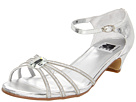

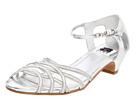

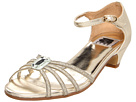

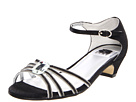

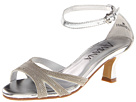

In [77]:
# for i in res.nlargest(n).index.to_list():
#     cv2_imshow(cv2.imread(paths[i]))
# res

In [83]:
res.nlargest(n).index.to_list()

AttributeError: ignored

Voting

In [0]:
!ls *.list2

h_haral.list2  h_hu.list2	s_haral.list2  s_hu.list2
h_hist.list2   h_seghist.list2	s_hist.list2   s_seghist.list2
h_hog.list2    h_vggfeat.list2	s_hog.list2    s_vggfeat.list2


fset: list of feature sets for multiple knn models

pset: p value for metric evaluation of models

weights: importance of each knn (experimental)

x: index of image to search

n: #neighbours

In [0]:
fset = [['h_vggfeat'], ['h_seghist','h_haral', 'h_hog'], ['h_hist','h_haral', 'h_hog']]
pset = [1,2, 3]
# weights = [1, 0.9, 0.8]
x = 78
n = 100

In [106]:

ndic = list()
for i in tqdm(range(len(fset))):
    features = features = stack_features(fset[i])
    neigh = NearestNeighbors(n_neighbors=10, p=pset[i])
    neigh.fit(features)
    neighbours = neigh.kneighbors(features[x:x+1], n, return_distance=False)
    ndic.append(neighbours.tolist()[0])
# pd.DataFrame(ndic)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


h_vggfeat.list2  loaded!
h_seghist.list2  loaded!
h_haral.list2  loaded!
h_hog.list2  loaded!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """
 67%|██████▋   | 2/3 [00:06<00:03,  3.45s/it]

h_hist.list2  loaded!
h_haral.list2  loaded!
h_hog.list2  loaded!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """
100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


In [0]:
flist = dict()
for j, ns in enumerate(ndic):
    for i in range(len(ns)):
        if ns[i] not in flist.keys():
            flist[ns[i]] = i
        else:
            flist[ns[i]] += i
res = [k[0] for k in sorted(flist.items(), key=lambda x: x[1])][:n]

In [0]:
# flist, ndic, res
bhak['vot'] = res

In [109]:
storeData(bhak, 'hoist')

hoist.pkl saved!


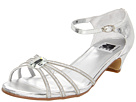

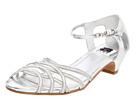

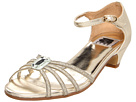

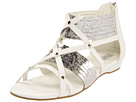

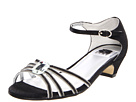

In [82]:
for i in res:
    cv2_imshow(cv2.imread(paths[i]))
# res